# Topic Modelling
Topic Modelling is a form of unsupervised learning that aims to find topic clusters in a series of texts. We will be using LDA, which is one of the most popular forms of doing Topic Modelling



## Imports

In [1]:
import scipy
import gensim
from gensim import corpora
import pandas as pd
from gensim import models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import pprint

## Download Data
Download the data that has been already been prepreprocessed.

In [2]:
letters = pd.read_csv('data/preprocessed_letters.csv')

In [3]:
#check to see what column names we're working with
print(letters.columns)

Index(['keys', 'letter', 'year'], dtype='object')


Extract all the letters and their keys into two separate lists

In [4]:
letterkeys = list(letters["keys"])
lettervalues = list(letters["letter"])

## Additional Preprocessing
Note: a lot of this code was copied from or modified from this tutorial: https://tomvannuenen.medium.com/analyzing-reddit-communities-with-python-part-5-topic-modeling-a5b0d119add, along with referencing code from the "Clustering_TopicModelling" notebook.
We are evaluating the quality of the model using cv Coherence Scores. Originally, creating a model simply using the preprocessed data gave coherence scores of at most 0.38, which is quite poor. The model quality was improved by doing the following:
1. Through trial and error, creating a list of words that appeared in too many topics/were too vague to provide information.
2. Not using a straightforward BOW model, but rather using bigrams and trigrams when possible.
3. Running a search for the optimal number of topic clusters to search for.

The very first model run had a Coherence score of about 0.35, optimizing topic clusters got it to 0.38, then removing common words got it to 0.44, adding bigrams and trigrams to 0.47, and finally searching for optimal topic number gave the final model with a coherence score of 0.51.
and the final model has a score of 0.51. We also tried removing all types of words that were not nouns or adjectives, but the performance of the model dropped rather than improved, so it was left as is.

changed the bigram creation threshold, and the dictioanry filter values
eval_every = 20, chunksize and passes in the model

Additional preprocessing is as follows

The way the preprocessed letters have been stored has removed the tokenization. We can simply split each letter into its own list of tokens once again.

In [5]:
#split into tokens
splitletters = []
for letter in lettervalues:
    splitletters.append(letter.split())

From now on, we will be working with these split letter values

From trial and error, we have noted that there are some words that appear excessively. These have been compiled and manually removed

In [7]:
# List of words to remove
wordstoremove = {"get", "go", "one", "david", "may", "good", "letter", "think", "send", "day", "time", "come", "take", "1917", "well", "say", "tell", "write", "two"
,"know","much","would","make", "could", "would"}

# remove unwanted words
filtered = [
    [word for word in sublist if word not in wordstoremove]
    for sublist in splitletters
]


### Add Bigrams and Trigrams
We used gensim's Phrases to create bigrams and trigrams. Bigrams and trigrams were created out of consecutive words only if the pair/trio of words appeared in at least 5 letters, and if their association strength was a standard 10 (threshold)

In [8]:
bigram = gensim.models.Phrases(filtered, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[filtered], threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [9]:
def getngrams(doc):
    bigrams = bigram_mod[doc]          
    trigrams = trigram_mod[bigrams] 
    return trigrams

enrichedtexts = []
for doc in filtered:
    enrichedtexts.append(getngrams(doc))

## Constructing Corpora

We need to create a dictionary out of our data using gensim's Dictionary.

In [10]:
dictionary = corpora.Dictionary(enrichedtexts)
print('Number of unique tokens:', len(dictionary))


Number of unique tokens: 7856


We will remove words that appear in less than 5 letters or in more than 0.99 of them

In [11]:
dictionary.filter_extremes(no_below=5, no_above=0.99)
print('Number of unique tokens:', len(dictionary))

Number of unique tokens: 2070


Create a BOW representation of the documents

In [12]:
bow_corpus = [dictionary.doc2bow(d) for d in enrichedtexts]

Finally we can run a first model.

In [14]:
ldamodel = models.ldamodel.LdaModel(bow_corpus, num_topics=8, id2word = dictionary,
                                           eval_every = 20,
                                           random_state = 100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)

# Visualization and First Analysis

We can visualize topic clusters in the following diagram.

In [16]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(ldamodel, bow_corpus, dictionary)
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.088039  0.009043       1        1  40.957788
3     -0.098534  0.008674       2        1  40.743159
5     -0.071941  0.023218       3        1  11.747322
2      0.279045  0.295685       4        1   4.345975
6      0.327303 -0.267166       5        1   1.568554
1     -0.113950 -0.014171       6        1   0.302309
0     -0.122001 -0.045096       7        1   0.280792
7     -0.111883 -0.010187       8        1   0.054101, topic_info=            Term        Freq       Total Category  logprob  loglift
313      suppose  110.000000  110.000000  Default  30.0000  30.0000
371        since  116.000000  116.000000  Default  29.0000  29.0000
234         ever   97.000000   97.000000  Default  28.0000  28.0000
114          lot  113.000000  113.000000  Default  27.0000  27.0000
240         fine   74.000000   74.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
826        nerve    0.010444   12.472473   Topic8  -7.6816   0.4369
1814      author    0.010444    2.431874   Topic8  -7.6816   2.0717
680        mount    0.010444   12.287442   Topic8  -7.6816   0.4518
50       darling    0.010444   35.722687   Topic8  -7.6817  -0.6155
1603  positively    0.010443    6.836596   Topic8  -7.6817   1.0380

[472 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
459       1  0.108014      1
459       2  0.594077      1
459       5  0.243031      1
459       7  0.027003      1
461       1  0.138651     10
...     ...       ...    ...
1617      2  0.280637  wound
1617      3  0.712385  wound
332       1  0.674983   yard
332       5  0.321421   yard
2056      4  0.934855    yet

[692 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 3, 7, 2, 1, 8])

Besides this qualitative analysis, we can compute the coherence score

In [17]:
coherence_model = CoherenceModel(model=ldamodel, corpus=bow_corpus, texts=enrichedtexts, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.4521471872912326


## Optimizing
Now we want to improve on this coherence score
took inspiration from but wrote my own funct

removed eval every and per word topic as it would slow thigns down too much
since the sampel size is pretty small i set the size of the model as is

In [78]:
def compute_coherence_values(dictionary, corpus, letters, limit=16, start=3, step=3):
    """
    Smth
    """    
    coherencelist = []
    modellist = []
    total_amount = limit / step
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                    id2word=dictionary, num_topics=num_topics,
                    random_state=100, update_every=1, chunksize=200, 
                    passes=40, alpha='auto', per_word_topics=False)
        modellist.append(model)
        coherencemodel = CoherenceModel(model=model, texts=letters,   
                    dictionary=dictionary, coherence='c_v')  
        coherencelist.append(coherencemodel.get_coherence())
        print("Built Model")
    return modellist, coherencelist

In [79]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, letters=enrichedtexts)

Built Model
Built Model
Built Model
Built Model
Built Model


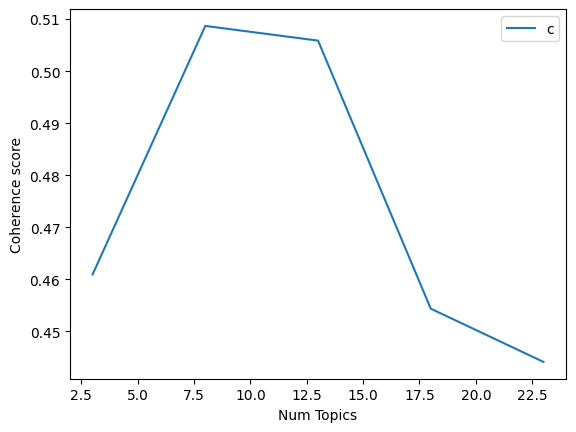

In [80]:
%matplotlib inline
limit=25; start=3; step=5
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

best model is the second etc etc
whole, except, many, happen, 

now we can look at the topics its created

In [83]:

optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pp(optimal_model.print_topics(num_words=20))

[(0,
  '0.019*"receive" + 0.017*"card" + 0.016*"july" + 0.014*"thank" + '
  '0.014*"wound" + 0.013*"prisoner" + 0.012*"ear" + 0.011*"holzminden" + '
  '0.010*"son" + 0.010*"aug" + 0.009*"love" + 0.008*"dugout" + 0.008*"since" + '
  '0.008*"doctor" + 0.007*"thanks" + 0.007*"heberden" + 0.007*"enclose" + '
  '0.007*"holland" + 0.007*"camp" + 0.007*"address"'),
 (1,
  '0.010*"mrs." + 0.006*"photo" + 0.006*"paper" + 0.006*":" + 0.005*"use" + '
  '0.005*"perhaps" + 0.005*"p.s" + 0.005*"new" + 0.005*"kitchen" + '
  '0.005*"clerk" + 0.005*"month" + 0.005*"price" + 0.005*"business" + '
  '0.004*"mention" + 0.004*"1st" + 0.004*"dream" + 0.004*"builder" + '
  '0.004*"woman" + 0.004*"remember" + 0.004*"list"'),
 (2,
  '0.006*"whole" + 0.005*"order" + 0.005*"pretty" + 0.005*"road" + '
  '0.005*"fire" + 0.005*"however" + 0.005*"platoon" + 0.005*"something" + '
  '0.004*"along" + 0.004*"always" + 0.004*"mile" + 0.004*"number" + '
  '0.004*"except" + 0.004*"although" + 0.004*"company" + 0.004*"play" 

war location descriptions and love
mundane life and errands
movement, and life at the front
war effects, focusing more on impact and destruction, urban bombing
mundane descriptions of time, the weather, daily routine
food rations
military structure
general reflection
travel and love

#TBD????
1. making a df of the terms. like now what. just qualitative analysis of the topics?
2. look at specific letters in the categories?
3. make the other graph per topic
4. the conclusion and connect to sentiment analysis

In [105]:
import pandas as pd

# Assuming you already have:
# - lda_model: your trained gensim LDA model
# - corpus: your documents in Bag-of-Words format
# - original_texts: list of the original text documents (same order as `corpus`)

# Get topic distributions for each document
topic_assignments = []
for doc_bow in enrichedtexts:
    topics = optimal_model.get_document_topics(doc_bow)
    # Get the topic with the highest probability
    dominant_topic = max(topics, key=lambda x: x[1])[0]
    topic_assignments.append(dominant_topic)

# Create a DataFrame
df = pd.DataFrame({
    'Document': original_texts,
    'Dominant_Topic': topic_assignments
})

# (Optional) Preview
print(df.head())


ValueError: too many values to unpack (expected 2)

In [109]:
import numpy as np

docs_id = letterkeys

doc2topics = np.zeros((len(docs_id), optimal_model.num_topics))

for di, doc_topics in enumerate(optimal_model.get_document_topics(bow_corpus, minimum_probability = 0)):
    for ti, v in doc_topics:
        doc2topics[di, ti] = v

ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (8).

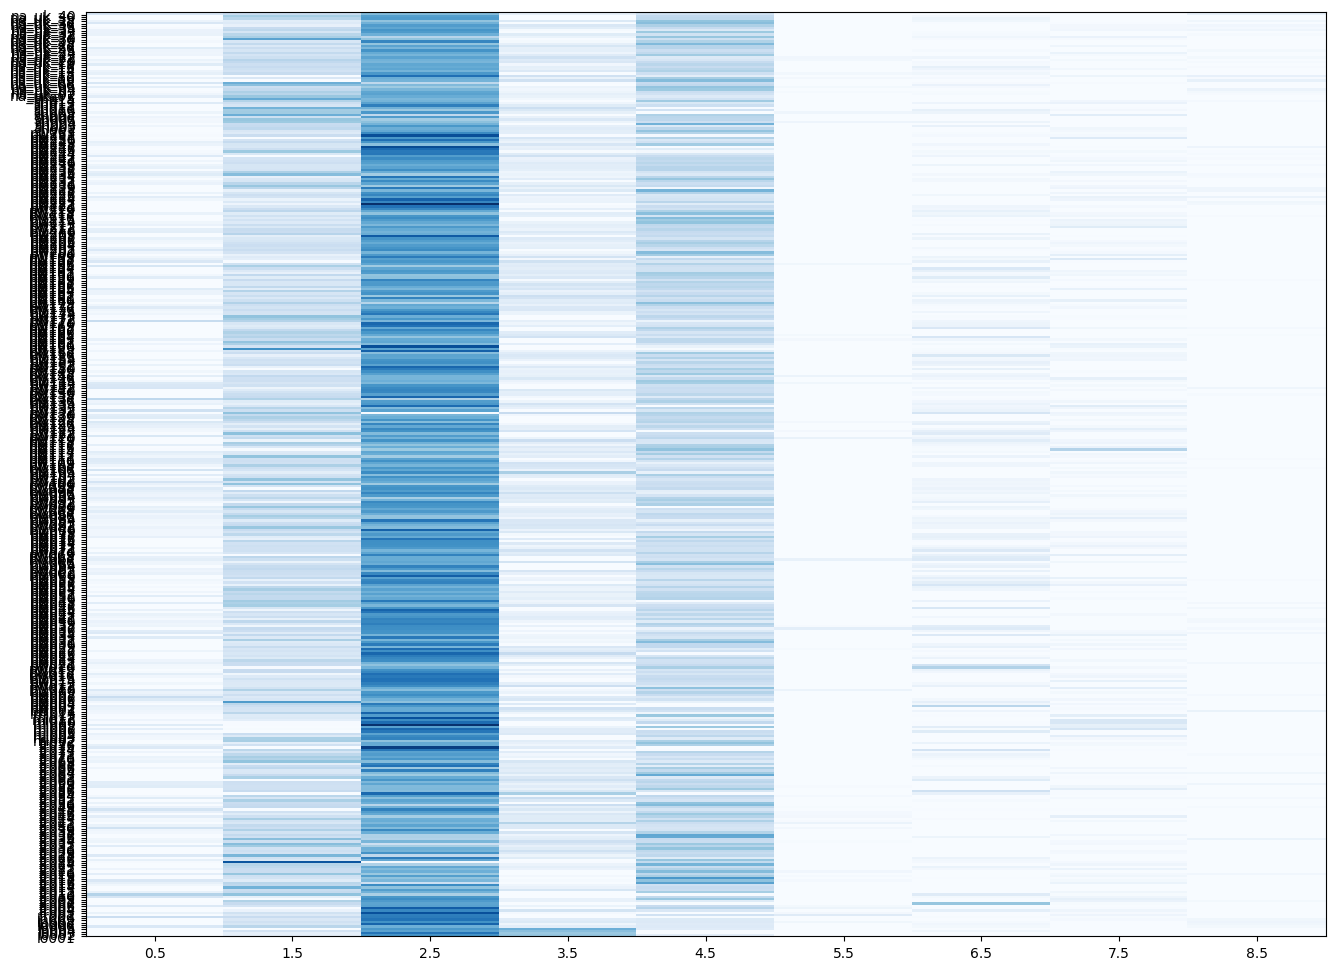

In [110]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 12))
plt.pcolor(doc2topics, norm=None, cmap='Blues')
plt.yticks(np.arange(doc2topics.shape[0]), docs_id)
plt.xticks(np.arange(doc2topics.shape[1])+0.5, ["Topic #"+str(n) for n in range(inaug_ldamodel.num_topics)], rotation = 90)
plt.colorbar(cmap='Blues')  # plot colorbar
plt.tight_layout()  # fixes margins
plt.show()